## Sentiments and Stocks

In a world where information can reach anyone within an instant owing to developments in technology - it is unsurprising to observe that news on particular topics can quicky alter our opinions on the subject - whether it be for celebrities, sports teams, or even stocks. This is especially so with the emphasis on criteria such as ESG scores - the '`set of standards for a company’s operations that socially conscious investors use to screen potential investments`'. This project aims to investigate the relationship between ESG articles related to specific stocks and analyse their potential impact (if any) on stock performance. 

*24/12/24 - 27/12/24*

In [1]:
import pandas as pd # please ensure the necessary libraries have been installed beforehand - the requirements.txt file can be used
import spacy
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import requests
from fake_useragent import UserAgent

In [2]:
file_path = r"ESG_daily_news.csv" # amend the file_path variable as need be

# The source of the dataset is this link: https://www.kaggle.com/datasets/debashish311601/daily-esg-news-and-headlines

In [3]:
df = pd.read_csv(file_path)

In [4]:
df.info() # with only 1 NA value in the entire dataset -> that can be dropped fairly quickly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      345 non-null    object
 1   headline  345 non-null    object
 2   text      344 non-null    object
dtypes: object(3)
memory usage: 8.2+ KB


In [5]:
df = df.dropna()
df["Date"] = pd.to_datetime(df["Date"]) # the Date column is also reshaped to a more proper datatype

In [6]:
days_prior, days_after = -3, 3 # this piece of code aims to create a range of values for which the price of stocks
# for the companies mentioned in the article can be compared against -> with the directionality of -3 and 3 being the dates 
# before and after the release of the article. They can be amended as one sees fit - however I decidied to choose 3 days in advance of the 
# article's release date to decrease the likelihood of this news being known in the first place (hence getting a sort of baseline stock value)
# and looking 3 days in advance to see the full ramifications of the news once it becomes widespread (given the chance). 

df["Date_range"] = df["Date"].apply(lambda x: ((x+pd.Timedelta(days=days_prior)).date(), (x+pd.Timedelta(days=days_after)).date()))
df.head()

,Date,headline,text,Date_range
0,2022-11-28,Top-Ranked Hedge Fund Makes Contrarian Bet on ...,As most techology stocks reel from higher inte...,"(2022-11-25, 2022-12-01)"
1,2022-11-27,Deutsche Bank’s DWS CEO Mulls New Legal Setup,DWS Group CEO Stefan Hoops is considering chan...,"(2022-11-24, 2022-11-30)"
2,2022-11-24,"JPMorgan, Deutsche Bank Sued by Epstein Accusers",JPMorgan Chase & Co. and Deutsche Bank AG were...,"(2022-11-21, 2022-11-27)"
3,2022-11-23,Tech Job Cuts Increase ‘Anxiety’ Across Industry,"After years of exuberant growth and hiring, la...","(2022-11-20, 2022-11-26)"
4,2022-11-22,"Amundi, DWS Reclassify Funds in Major Industry...",Amundi and Deutsche Bank’s DWS Group are downg...,"(2022-11-19, 2022-11-25)"


In [7]:
nlp = spacy.load("en_core_web_md") # spacy's medium english model has been downloaded in advance

In [8]:
def entities(text,ents_ = ["ORG"]): # the entities recognised in the code is limited to organisations (this can be further extended to people)
    # to establish a greater connection to companies as well - for e.g. ELON MUSK as the owner of TSLA - though to keep things simple
    # I focus solely on organisations themselves
    doc = nlp(text)
    res = {} 
    for e in ents_:
        res[e]=[ent for ent in doc.ents if ent.label_==e]
    return res 

In [9]:
df["text_org"] = df["text"].apply(lambda x: entities(x)["ORG"])

In [10]:
model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

# The crux of this project lies in having a sentiment analysis model at the ready. Since the data is already unlabelled, I decided
# to choose a pretrained sentiment analysis model that can classify text into 3 main categories -> positive, neutral and negative sentiments
# Owing to this model having been trained on a corpus of financial texts; I considered it to be fairly suitable for the project - though
# training a model with labelled data would indeed have been preferential 

sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
df["text_sent"] = df["text"].apply(sentiment)
df.head()

# we can see tht while pretty alright - the text sentiment categorisation isn't perfect - for example the third row is 
# neutral w a confidence of 0.41 -> below the majority of 0.5 and also on a subject related to 'suing' and other nefarious deeds.
# We shall thus compare the scoring of sentiments amongst all the articles to see how well the labels are

,Date,headline,text,Date_range,text_org,text_sent
0,2022-11-28,Top-Ranked Hedge Fund Makes Contrarian Bet on ...,As most techology stocks reel from higher inte...,"(2022-11-25, 2022-12-01)","[(Facebook), (Meta, Platforms), (the, Liontrus...","[{'label': 'positive', 'score': 0.890140175819..."
1,2022-11-27,Deutsche Bank’s DWS CEO Mulls New Legal Setup,DWS Group CEO Stefan Hoops is considering chan...,"(2022-11-24, 2022-11-30)","[(DWS, Group), (Deutsche, Bank, ’s), (Hoops), ...","[{'label': 'neutral', 'score': 0.5695429444313..."
2,2022-11-24,"JPMorgan, Deutsche Bank Sued by Epstein Accusers",JPMorgan Chase & Co. and Deutsche Bank AG were...,"(2022-11-21, 2022-11-27)","[(JPMorgan, Chase, &, Co.), (Deutsche, Bank, A...","[{'label': 'neutral', 'score': 0.4088113605976..."
3,2022-11-23,Tech Job Cuts Increase ‘Anxiety’ Across Industry,"After years of exuberant growth and hiring, la...","(2022-11-20, 2022-11-26)","[(Challenger, ,, Gray, &, ChristmasThe), (Hewl...","[{'label': 'negative', 'score': 0.999315381050..."
4,2022-11-22,"Amundi, DWS Reclassify Funds in Major Industry...",Amundi and Deutsche Bank’s DWS Group are downg...,"(2022-11-19, 2022-11-25)","[(Deutsche, Bank, ’s), (DWS, Group), (EU), (ES...","[{'label': 'neutral', 'score': 0.9936017394065..."


In [12]:
sent_types = {'positive':1,'neutral':0,'negative':-1}

df['text_sentiment'] = df['text_sent'].apply(lambda x:sent_types[x[0]['label']])
# the information from the model is then encoded using the 'sent_types' dictionary above

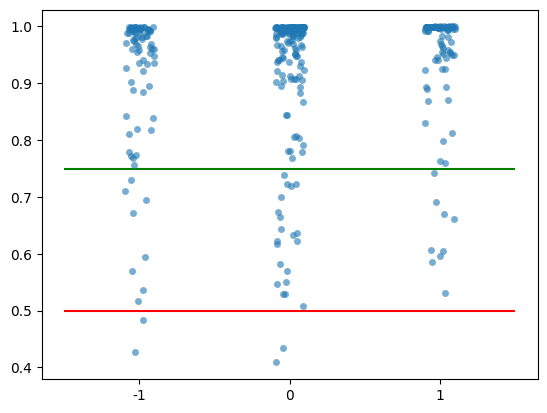

In [13]:
sentiment_confidence = list(df["text_sent"].apply(lambda x:(x[0]['label'],x[0]['score'])).values)
sentiments, confidence_lvl = zip(*sentiment_confidence)
encoded_sentiments = list(map(lambda x: sent_types[x],sentiments))

sns.stripplot(x = encoded_sentiments,y = confidence_lvl, alpha = 0.6)
lower_x, upper_x = (plt.xlim())
plt.hlines(y = 0.5, xmin = lower_x, xmax = upper_x, color = 'red')
plt.hlines(y = 0.75, xmin = lower_x, xmax = upper_x, color = 'green')
plt.show()

# On the x axis; the -1, 0 and 1 values correspond to texts that are categorised as having negative, neutral and positive sentiments respectively
# The y axis shows the confidence of the score (from 0 - 1) of the ranking given the content of the article. As we can see, there are some
# neutral and negative articles that don't seem to hold a high level of confidence - yet ultimately a majority of texts do have a ranking
# above 0.75 which is undeniably substantial

In [14]:
df['text_org'] = df['text_org'].apply(lambda x:sorted(set(str(i) for i in x)))

In [15]:
def get_ticker(company_name): # this code aims to get the ticker information of the companies listed in the article
    # For example, the company Amazon has the stock ticker AMZN; while that of Facebook has the ticker META
    yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
    user_agent = UserAgent().random 
    params = {"q": company_name, "quotes_count": 1, "country": "United States"}

    res = requests.get(url=yfinance, params=params, headers={'User-Agent': user_agent})
    try:
        data = res.json()
        company_code = data['quotes'][0]['symbol']
        return company_code
    except:
        return None

In [16]:
df['org_ticker'] = df['text_org'].apply(lambda x:[get_ticker(k) for k in x])
df['org_ticker'] = df['org_ticker'].apply(lambda x: sorted(set(filter(lambda y:y!=None,x))))
df['org_ticker']

0                                                [META]
1      [0P0001R0QK.F, AIQ, DB, DWS.BE, GS, HSCT, XAI=F]
2                                      [DB, JPM, SXB=F]
3                               [AMZN, CGF.AX, HP, HPE]
4                         [0P0000853L, DWS.BE, ESG, EU]
                             ...                       
340                                                  []
341                                                  []
342                                                  []
343                                              [AMZN]
344                                             [EGRNF]
Name: org_ticker, Length: 344, dtype: object

In [17]:
all_tickers = [] # all of the tickers are then collated together into one list

for l in df['org_ticker'].values:
    all_tickers+= l 
    all_tickers = sorted(list(set(all_tickers)))

In [18]:
ticker_info = {} 
failed_tickers = []
for t in all_tickers:
    try:
        ticker_info[t] = yf.download(tickers=t) # and the necessary ticker information for all time as has been recorded is collated into
        # a dictionary with the key being the ticker itself and the value being a dataframe of all the relevant information for ease of lookups
    except:
        failed_tickers.append(t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['0I71.F']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1926-01-21 -> 2024-12-27)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*********

In [19]:
def stock_price(ticker, start_date, end_date): # the stock price is then collected for particular dates given the stocks present 
    if ticker in failed_tickers:
        return None 
    else:
        df = ticker_info[ticker]
        df.index = pd.to_datetime(df.index).date
        start_close = df[df.index == start_date]['Close'] 
        if (list(start_close.values) == []):
            return None 
        else:
            start_price = df[df.index == start_date]['Close'].values[0][0]
            end_close = df[df.index == end_date]['Close']
            while (list(end_close.values) == []):
                end_date+=pd.Timedelta(days = 1)
                end_close = df[df.index == end_date]['Close']
            end_price = df[df.index == end_date]['Close'].values[0][0]
            return (start_price,end_price)

In [20]:
res = []
for i, row in df.iterrows():
    orgs = row['org_ticker']
    if len(orgs) == 0:
        res.append(None)
    else:
        mini_res = {}
        for i,k in enumerate(orgs):
            mini_res[k] = ((stock_price(row['org_ticker'][i],row["Date_range"][0],row["Date_range"][-1])))
        value_set = (set(mini_res.values()))
        if (len(value_set)==1) and list(value_set)[0]== None:
            res.append(None)
        else:
            res.append({k:v for k,v in mini_res.items() if v!=None})

In [21]:
df["start_end"] = res

In [22]:
dfc = df.dropna().copy(deep=True) # a copy of the dataframe is made for further information to be created in more columns, namely

dfc["co_diff"] = dfc["start_end"].apply(lambda x: sorted([(k,(v[1] - v[0])/(v[0])*100) for k,v in x.items()],key = lambda z:z[-1]))
# the percentage ifference between the stock price for each organisation's stock (which can be found) between the start and end date range
dfc["co_values"] = dfc["co_diff"].apply(lambda x: list(map(lambda y: y[-1], x)))
# the sole value of that difference (without the corresponding stock ticker)

C:\Users\Acer\AppData\Local\Temp\ipykernel_1720\1063798695.py:3: RuntimeWarning: invalid value encountered in scalar divide
  dfc["co_diff"] = dfc["start_end"].apply(lambda x: sorted([(k,(v[1] - v[0])/(v[0])*100) for k,v in x.items()],key = lambda z:z[-1]))


In [23]:
dfc.head() # the information can be seen below.
# We can see that for the very first row, we have organisations and entities such as Facebook, Meta and the MSCI USA Index listed
# For which some of them (namely Fb and Meta) have stock tickers (shared as META) that are listed under the 'org_ticker' column.

# We then find the respective price at (or very close to) the start and end of the date ranges in the 'Date_range' column and
# express that difference as a percentage uptick/ downtick from the starting price

,Date,headline,text,Date_range,text_org,text_sent,text_sentiment,org_ticker,start_end,co_diff,co_values
0,2022-11-28,Top-Ranked Hedge Fund Makes Contrarian Bet on ...,As most techology stocks reel from higher inte...,"(2022-11-25, 2022-12-01)","[Facebook, MSCI USA ETFSeparately, Meta, Meta ...","[{'label': 'positive', 'score': 0.890140175819...",1,[META],"{'META': (111.41000366210938, 120.440002441406...","[(META, 8.105195657908396)]",[8.105195657908396]
1,2022-11-27,Deutsche Bank’s DWS CEO Mulls New Legal Setup,DWS Group CEO Stefan Hoops is considering chan...,"(2022-11-24, 2022-11-30)","[DWS, DWS Group, Deutsche Bank’s, Deutsche ban...","[{'label': 'neutral', 'score': 0.5695429444313...",0,"[0P0001R0QK.F, AIQ, DB, DWS.BE, GS, HSCT, XAI=F]","{'DWS.BE': (30.34000015258789, 30.459999084472...","[(DWS.BE, 0.3955139462137746)]",[0.3955139462137746]
2,2022-11-24,"JPMorgan, Deutsche Bank Sued by Epstein Accusers",JPMorgan Chase & Co. and Deutsche Bank AG were...,"(2022-11-21, 2022-11-27)","[Bank, Deutsche Bank AG, EpsteinThe, JPMorgan ...","[{'label': 'neutral', 'score': 0.4088113605976...",0,"[DB, JPM, SXB=F]","{'DB': (10.4399995803833, 10.539999961853027),...","[(DB, 0.9578580985542059), (JPM, 0.97707855839...","[0.9578580985542059, 0.9770785583913876]"
5,2022-11-21,Amundi Joins Growing List of Firms Downgrading...,"Amundi, Europe’s largest asset manager, is rem...","(2022-11-18, 2022-11-24)","[Axa Investment Management, BlackRock, ESG, EU...","[{'label': 'neutral', 'score': 0.9990572333335...",0,"[BLK, ESG, EU]","{'BLK': (720.6099853515625, 737.780029296875),...","[(ESG, 1.5175836078230223), (BLK, 2.3827096896...","[1.5175836078230223, 2.382709689616053, 22.065..."
6,2022-11-21,COP27 Approves Last-Ditch Historic Climate Deal,"The COP27 climate talks in Egypt, which came c...","(2022-11-18, 2022-11-24)",[COP],"[{'label': 'negative', 'score': 0.426503360271...",-1,[HG=F],"{'HG=F': (3.631999969482422, 3.626499891281128)}","[(HG=F, -0.15143387245341122)]",[-0.15143387245341122]


In [24]:
sentiment_price = {1:[],0:[],-1:[]} 

for i,r in dfc.iterrows():
    sentiment_price[(r['text_sentiment'])]+= r["co_values"] # all of the percentage changes are then collated into the dictionary above
    # based on the sentiment of the article itself

# We would expect to observe a clear trend where articles with positive sentiments have more of an increase in prices compared to 
# articles where the stocks are portrayed negatively   

In [25]:
x_res = []
y_res = []
for k,v in sentiment_price.items():
    x_res+=([k]*len(v))
    y_res += v

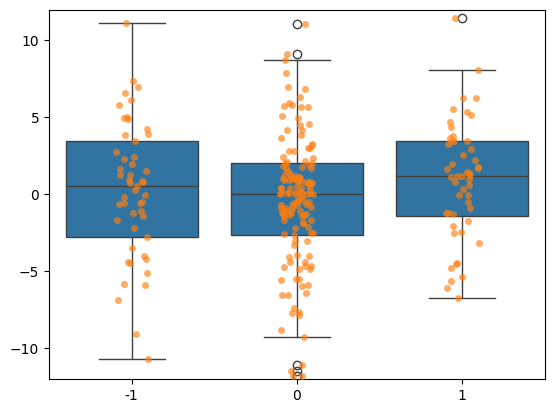

In [26]:
sns.boxplot(x = x_res,y = y_res)
sns.stripplot(x = x_res,y = y_res, alpha = 0.65)
plt.ylim((-12,12))
plt.show() 

## Conclusion

Indeed, this does appear to hold true *somewhat*, with articles with positive sentiments having more of an increase in stock
prices compared to those where the sentiments are negative. Unsurprisingly, there is a great spread of percentage changes for neutral articles - though they are notably clustered around 0. 

However, it is noteworthy that there doesn't appear to be that great of a statistically significant 
difference in the price changes of the stocks - which could be improved by more appropriate categorisation of articles to their proper 
sentiments, as well as the realisation that the overall sentiment of the article may be different than its impact on stocks themselves.

Further models can thus be tailored towards sentence based sentimenta analysis of documents with a specific entity recogniser curated
towards companies that have listed stocks themselves.